# MERS

In [4]:
import sys
sys.path.append("../notebooks/scripts")

# Imports Section 

In [5]:
import altair as alt
from altair_saver import save
import Bio.Phylo
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import re
import seaborn as sns

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [7]:
alt.renderers.set_embed_options(
    padding={"left": 0, "right": 0, "bottom": 1, "top": 1}
)

RendererRegistry.enable('default')

In [8]:
sns.set_style("ticks")
# Disable top and right spines.
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
# Display and save figures at higher resolution for presentations and manuscripts.
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.dpi'] = 100
# Display text at sizes large enough for presentations and manuscripts.
mpl.rcParams['font.weight'] = "normal"
mpl.rcParams['axes.labelweight'] = "normal"
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 8
mpl.rc('text', usetex=False)

In [9]:
try: 
    snakemake.input.node_df
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


# MERS Specific Variables

In [10]:
try:
    colors = snakemake.input.colors
    node_df = snakemake.input.node_df

    pca_df = snakemake.input.pca_df
    explained_variance_pca = snakemake.input.explained_variance_pca

    mds_df = snakemake.input.mds_df
    tsne_df = snakemake.input.tsne_df
    umap_df = snakemake.input.umap_df

    #Scatterplot:
    scatterplot_pca = snakemake.input.scatterplot_pca
    scatterplot_pca_metadata = snakemake.input.scatterplot_pca_metadata

    scatterplot_mds = snakemake.input.scatterplot_mds
    scatterplot_mds_metadata = snakemake.input.scatterplot_mds_metadata

    scatterplot_tsne = snakemake.input.scatterplot_tsne
    scatterplot_tsne_metadata = snakemake.input.scatterplot_tsne_metadata

    scatterplot_umap = snakemake.input.scatterplot_umap
    scatterplot_umap_metadata = snakemake.input.scatterplot_umap_metadata

    #KDE Density:
    KDE_pca = snakemake.input.KDE_pca
    KDE_pca_metadata = snakemake.input.KDE_pca_metadata

    KDE_mds = snakemake.input.KDE_mds
    KDE_mds_metadata = snakemake.input.KDE_mds_metadata

    KDE_tsne = snakemake.input.KDE_tsne
    KDE_tsne_metadata = snakemake.input.KDE_tsne_metadata

    KDE_umap = snakemake.input.KDE_umap
    KDE_umap_metadata = snakemake.input.KDE_umap_metadata
    
    KDE_genetic = snakemake.input.KDE_genetic
    KDE_genetic_metadata = snakemake.input.KDE_genetic_metadata
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


In [11]:
#Use colors.tsv file to generate these 

domain = ["other"] + ["clade_" + str(x) for x in range(0,37)]



In [17]:
range_df = pd.read_csv("config/colors.tsv", sep="\t", header=None)

In [20]:
range_df.columns = ["membership", "clade_name", "color"]

In [29]:
range_ = range_df["color"].values.tolist()[:38]

In [27]:
len(range_df["color"].values.tolist()[:37])

37

In [ ]:
range_ = ['#000000', '#5c22be', '#5330cd', '#71c4ac', '#e7cf4b', '#ff9a3c', '#ff8939', '#ff7535', '#ff6131', '#fd4b2c', '#f93529', '#4b3ddb', '#474ee3', '#4760e9', '#4971eb', '#4b82e9', '#4f92e5',
          '#549fdc', '#5aabd3', '#61b4c6', '#68bdba', '#7bca9d', '#86ce91', '#91d283', '#9dd478', '#aad66d', '#b6d764', '#c3d65c', '#cfd555', '#dcd34f', '#e7cf4b', '#f9c244', '#ffb642', '#ffaa3f', '#A17070', '#B9B7BC', '#D5D4D7', '#6F6E70' ]

In [53]:
len(domain)

38

# Trying out MERS

In [30]:
#node_df = pd.read_csv(node_df, sep="\t")
node_df = pd.read_csv("results/table.tsv", sep="\t")
node_df["multihost_clade_membership"] = node_df["multihost_clade_membership"].sort_values().fillna("other")
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)

In [31]:
node_df

,strain,date,host,pca1,pca2,pca3,pca4,mds1,mds2,tsne_x,tsne_y,umap_x,umap_y,clade_membership,multihost_clade_membership,pca_label,mds_label,umap_label,t-sne_label,y
0,EMC/2012|JX869059|human|2012-06-13,2012.45,human,-9.99,-5.85,7.26,-3.58,-36.34,22.36,10.06,13.50,12.42,9.79,clade_0,clade_0,3.0,-1.0,0.0,3.0,1
1,Jordan-N3/2012|KC776174|human|2012-04-15,2012.29,human,-6.78,-0.44,-1.61,0.37,-20.25,-12.24,10.25,13.45,12.62,9.89,clade_0,clade_0,-1.0,-1.0,0.0,3.0,2
2,D998/15|KX108943|camel|2015-04-23,2015.31,camel,-8.93,-4.83,5.94,-2.73,44.43,27.93,9.50,12.64,11.75,9.04,clade_1,clade_1,4.0,-1.0,0.0,3.0,3
3,NRCE-HKU205|KJ477102|camel|2013-11-15,2013.87,camel,-3.57,8.76,-17.03,5.58,-44.36,-66.90,10.21,10.90,11.76,9.63,clade_1,clade_1,1.0,-1.0,0.0,3.0,4
4,Egypt_NRCE-NC163/2014|KU740200|camel|2014-12-17,2014.96,camel,-2.74,4.27,-11.44,2.83,-43.11,-32.73,10.82,11.93,11.95,9.41,clade_1,clade_1,1.0,-1.0,0.0,3.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,KOR/CNUH_SNU/024_06_2015|KT868867|human|2015-0...,2015.43,human,-7.90,-2.43,1.32,-1.25,-8.90,-9.40,-12.11,-24.69,16.76,-4.33,clade_32,clade_32,2.0,2.0,1.0,0.0,270
270,KOR/CNUH_SNU/030_06_2015|KT868868|human|2015-0...,2015.43,human,-7.90,-2.44,1.31,-1.25,-8.97,-9.51,-12.47,-25.34,15.86,-4.10,clade_32,clade_32,2.0,2.0,1.0,0.0,271
271,KOR/CNUH_SNU/023_06_2015|KT868866|human|2015-0...,2015.44,human,-7.90,-2.44,1.31,-1.25,-8.97,-9.51,-12.47,-25.34,16.09,-4.01,clade_32,clade_32,2.0,2.0,1.0,0.0,272
272,KOR/CNUH_SNU/031_06_2015|KT868869|human|2015-0...,2015.44,human,-7.90,-2.44,1.31,-1.25,-8.97,-9.51,-12.42,-24.98,16.41,-3.98,clade_32,clade_32,2.0,2.0,1.0,0.0,273


In [32]:
node_df["multihost_clade_membership"].value_counts().sort_values(ascending=False)

clade_32    30
other       29
clade_6     26
clade_29    24
clade_27    19
clade_13    16
clade_5     14
clade_26     8
clade_12     7
clade_20     6
clade_11     6
clade_1      5
clade_4      5
clade_16     5
clade_3      5
clade_9      5
clade_14     5
clade_36     4
clade_31     4
clade_22     4
clade_30     4
clade_7      4
clade_10     4
clade_28     3
clade_21     3
clade_25     3
clade_17     3
clade_23     3
clade_19     2
clade_18     2
clade_0      2
clade_15     2
clade_24     2
clade_35     2
clade_8      2
clade_33     2
clade_2      2
clade_34     2
Name: multihost_clade_membership, dtype: int64

# Running PCA on the Dataset

In [33]:
#principalDf = pd.read_csv(pca_df, index_col=0)
principalDf = pd.read_csv("results/embed_pca.csv", index_col=0)
#explained_variance_df = pd.read_csv(explained_variance_pca)
explained_variance_df = pd.read_csv("results/explained_variance_pca.csv")

NameError: name 'snakemake' is not defined

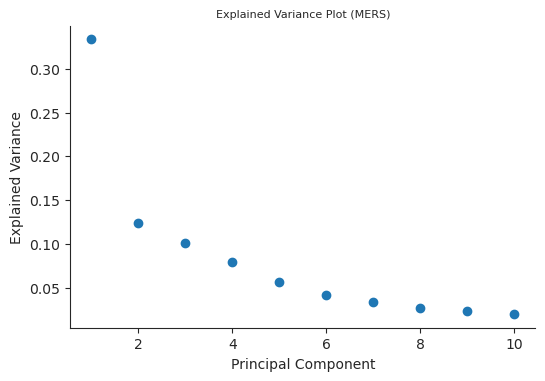

In [34]:
plt.plot(explained_variance_df['principal components'].values.tolist(), explained_variance_df["explained variance"].values.tolist(), 'o')

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")

plt.title(f"Explained Variance Plot (MERS)")

plt.savefig(snakemake.output.Explained_variance_PCA)

In [35]:
merged_pca_df = principalDf.merge(node_df[["strain", "date", "y", "host", "multihost_clade_membership"]], on="strain")

In [36]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

In [37]:
PCAFluBrush = scatterplot_with_tooltip_interactive(merged_pca_df,'pca1','pca2','PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",['strain', 'host'],'multihost_clade_membership:N', domain, range_)
PCAFluBrush

alt.Chart(...)

In [38]:
brush = alt.selection(type='interval', resolve='global')
chart = alt.Chart(merged_pca_df).mark_circle(size=60).encode(
    x=alt.X('pca1', title='PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")"),
    y=alt.X('pca2', title='PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")"),
    color=alt.Color("multihost_clade_membership:N", scale=alt.Scale(domain=domain, range=range_)),
    tooltip=["strain", "host"],
    shape='host:N'
).interactive()

points = chart.mark_point(filled=True).encode(
    color='multihost_clade_membership:N',
    shape='host'
)

alt.layer(
    chart,
    points
).resolve_scale(
    color='independent',
    shape='independent'
)
chart

alt.Chart(...)

In [39]:
alt.data_transformers.disable_max_rows()
alt.Chart(merged_pca_df).mark_boxplot().encode(
    x='pca1:Q',
    tooltip = ["strain"]
)

alt.Chart(...)

In [40]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "multihost_clade_membership:N",['strain', "host"], domain, range_)
chart_pca = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

chart_pca

alt.HConcatChart(...)

# Running MDS on Dataset

In [41]:
#MDS_df = pd.read_csv(mds_df,index_col=0)
MDS_df = pd.read_csv("results/embed_mds.csv",index_col=0)
merged_mds_df = MDS_df.merge(node_df[["strain", "date", "y", "host", "multihost_clade_membership"]], on="strain")

In [42]:
scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain'],'multihost_clade_membership:N', domain, range_)

alt.Chart(...)

In [43]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'multihost_clade_membership:N', ['strain'], domain, range_)
chart_mds = list_of_chart[0]|list_of_chart[1]

In [44]:
chart_mds

alt.HConcatChart(...)

# Running t-SNE on the Dataset

In [45]:
TSNE_df = node_df[["strain", "date", "y", "host", "multihost_clade_membership", "tsne_x", "tsne_y", "t-sne_label"]]

In [31]:
tsne_chart = scatterplot_with_tooltip_interactive(TSNE_df,'tsne_x','tsne_y','tsne_x','tsne_y',['strain', "multihost_clade_membership", "host"],'multihost_clade_membership:N', domain, range_)

NameError: name 'snakemake' is not defined

In [46]:
list_of_chart = linking_tree_with_plots_brush(
    TSNE_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'multihost_clade_membership:N',
    ["host:N","strain:N"],
    domain,
    range_
)
chart_tsne = list_of_chart[0]|list_of_chart[1]
chart_tsne

alt.HConcatChart(...)

In [47]:
brush = alt.selection(type='interval', resolve='global')
chart = alt.Chart(TSNE_df).mark_point(size=60, filled=True).encode(
    x=alt.X('tsne_x', title='tsne_x'),
    y=alt.X('tsne_y', title='tsne_y'),
    color=alt.Color("multihost_clade_membership:N", scale=alt.Scale(domain=domain, range=range_)),
    tooltip=["strain", "host","multihost_clade_membership"],
    shape=alt.Shape('host:N', scale=alt.Scale(range=["circle","cross"]))
).interactive()
chart

alt.Chart(...)

In [48]:
list_of_chart = linking_tree_with_plots_clickable(
    TSNE_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    't-sne_label:N',
    ["t-sne_label:N"],
    ["host:N","strain:N"]
)
chart_tsne = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart_tsne

alt.HConcatChart(...)

# Running UMAP on the Dataset

In [49]:
UMAP_df = node_df[["strain", "date", "y", "host", "multihost_clade_membership", "umap_x", "umap_y", "umap_label"]]

In [50]:
scatterplot_with_tooltip_interactive(UMAP_df,'umap_x','umap_y','umap_x','umap_y',['strain', "multihost_clade_membership", "host"],'multihost_clade_membership:N', domain, range_)

alt.Chart(...)

In [52]:
brush = alt.selection(type='interval', resolve='global')
chart = alt.Chart(UMAP_df).mark_point(size=60, filled=True).encode(
    x=alt.X('umap_x', title='umap_x'),
    y=alt.X('umap_y', title='umap_y'),
    color=alt.Color("multihost_clade_membership:N", scale=alt.Scale(domain=domain, range=range_)),
    tooltip=["strain", "host","multihost_clade_membership"],
    shape=alt.Shape('host:N', scale=alt.Scale(range=["circle","cross"]))
).interactive()
chart

alt.Chart(...)

In [37]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    UMAP_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'multihost_clade_membership:N',
    ["host","strain:N"],
    domain,
    range_
)
chart_umap = list_of_chart[0]|list_of_chart[1]
chart_umap

alt.HConcatChart(...)

In [38]:
list_of_chart = linking_tree_with_plots_clickable(
    UMAP_df,
    ['umap_x','umap_y'],
    ['umap_x','umap_y'],
    'umap_label:N',
    ["umap_label:N"],
    ["host:N","strain:N"]
)
chart_umap = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart_umap

alt.HConcatChart(...)

# Linking all Plots together

In [36]:
data = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca2', 'pca3', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
    'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",'UMAP1','UMAP2'],
    'multihost_clade_membership:N',
    ['strain','host', 'multihost_clade_membership'],
    domain,
    range_
)

In [40]:
PCAMDS = data[3]|data[1]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.vconcat(data[0],embeddings)
fullChart


NameError: name 'snakemake' is not defined

In [46]:
def linking_tree_with_plots_brush_mers(dataFrame, list_of_data, list_of_titles, color, ToolTip, shape, domain=None, range_=None):
    """Creates a linked brushable altair plot with the tree and the charts appended
    Parameters
    -----------
    dataframe: Pandas Dataframe
        dataframe including node data and dimensionality reduction data 
    list_of_data: list
        list of all the names of the columns in the dataframe for which you want graphs: goes in the order of [x1,y1,x2,y2,x3,y3] etc.
    list_of_titles: list
        list of all the TITLES you want for each axis: goes in order of[x1,y1,x2,y2,x3,y3] etc.
    color: string
        what the data should be colored by (ex. by clade, by region)
    ToolTip: list
        when hovering over the data, what data should be shown
        
    Returns
    ---------
    A brushable altair plot combining the tree with the plots of columns passed in
    """
    
    list_of_chart = []
    if(len(list_of_data) % 2 != 0 or len(list_of_titles) % 2 != 0):
        raise Exception(
            'The length of list_of_data and the length of list_of_titles should not be odd.')
    else:
        base = alt.Chart(dataFrame)
        brush = alt.selection(type='interval', resolve='global')
        tree_name = base.mark_point(size=60, filled=True).encode(
            x=alt.X(
                "date:Q",
                scale=alt.Scale(
                    domain=(dataFrame["date"].min() - 0.2, dataFrame["date"].max() + 0.2)),
                title="Date",
                axis=alt.Axis(labels=False, ticks=False)
            ),
            y=alt.Y(
                "y:Q",
                title="",
                axis=alt.Axis(labels=False, ticks=False)
            ),
            color=alt.condition(brush, if_false=alt.ColorValue('gray'), if_true=alt.Color(color, scale=alt.Scale(domain=domain, range=range_))),
            tooltip=ToolTip,
            shape=alt.Shape(shape, scale=alt.Scale(range=["cross","circle"]))
        ).add_selection(brush).properties(width=560, height=250)
        list_of_chart.append(tree_name)

        for i in range(0, len(list_of_data) - 1, 2):
            if(i == len(list_of_data)):
                break
            chart = base.mark_point(size=60,filled=True).encode(
                x=alt.X(list_of_data[i], title=list_of_titles[i], axis=alt.Axis(labels=False, ticks=False)),
                y=alt.X(list_of_data[i + 1], title=list_of_titles[i + 1], axis=alt.Axis(labels=False, ticks=False)),
                color=alt.condition(brush, if_false=alt.ColorValue('gray'), if_true=alt.Color(color, scale=alt.Scale(domain=domain, range=range_))),
                tooltip=ToolTip,
                shape=alt.Shape(shape, scale=alt.Scale(range=["cross","circle"]))
            ).add_selection(
                brush
            ).properties(
                width=250,
                height=250
            )
            list_of_chart.append(chart)
        return list_of_chart

In [47]:
data = linking_tree_with_plots_brush_mers(
    node_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca2', 'pca3', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
    'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",'UMAP1','UMAP2'],
    'multihost_clade_membership:N',
    ['strain','host', 'multihost_clade_membership'],
    'host:N',
    domain,
    range_
)

In [48]:
PCAMDS = data[3]|data[1]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.vconcat(data[0],embeddings)
fullChart
fullChart.save(snakemake.output.fullChart)
fullChart.save(snakemake.output.fullChartPNG, scale_factor=2.0)

alt.VConcatChart(...)

In [63]:
data = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'host:N',
    ['strain','multihost_clade_membership'],
    ["human", "camel"],
    ["orange", "blue"]
)

In [66]:
PCAMDS = data[3]|data[1]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChartHost = alt.vconcat(data[0],embeddings)
fullChartHost
fullChartHost.save(snakemake.output.fullChartHost)

alt.VConcatChart(...)

# Genetic Vs. Euclidean Distance Scatterplot

In [6]:
import matplotlib.gridspec as gridspec

In [81]:
total_df_PCA = pd.read_csv(scatterplot_pca,index_col=0)
metadata_PCA = pd.read_csv(scatterplot_pca_metadata, index_col=0)
total_df_MDS = pd.read_csv(scatterplot_mds,index_col=0)
metadata_MDS = pd.read_csv(scatterplot_mds_metadata, index_col=0)
total_df_TSNE = pd.read_csv(scatterplot_tsne,index_col=0)
metadata_TSNE = pd.read_csv(scatterplot_tsne_metadata, index_col=0)
total_df_UMAP = pd.read_csv(scatterplot_umap,index_col=0)
metadata_UMAP = pd.read_csv(scatterplot_umap_metadata, index_col=0)

In [52]:
fig = plt.figure(figsize=(8, 8), constrained_layout=False)
fig.tight_layout(pad=8.0)
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.8)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title(f"PCA ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (PCA)")
ax2.set_title(f"MDS ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title(f"t-SNE ($R^2={mean:.3f} +/- {std:.3f}$)")



mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title(f"UMAP ($R^2={mean:.3f} +/- {std:.3f}$)")


sns.despine()
plt.savefig(snakemake.output.Scatterplot, dpi=300)

NameError: name 'gridspec' is not defined

<Figure size 1728x432 with 0 Axes>

# KDE Density Plots

In [7]:
KDE_pca = "results/KDEDensity_pca.csv"
KDE_pca_metadata = "results/KDEDensity_pca_metadata.csv"

KDE_mds = "results/KDEDensity_mds.csv"
KDE_mds_metadata = "results/KDEDensity_mds_metadata.csv"

KDE_tsne = "results/KDEDensity_t-sne.csv"
KDE_tsne_metadata = "results/KDEDensity_t-sne_metadata.csv"

KDE_umap = "results/KDEDensity_umap.csv"
KDE_umap_metadata = "results/KDEDensity_umap_metadata.csv"

KDE_genetic = "results/KDEDensity_genetic.csv"
KDE_genetic_metadata = "results/KDEDensity_genetic_metadata.csv"


Genetic_KDE_df = pd.read_csv(KDE_genetic)
Genetic_KDE_metadata_df = pd.read_csv(KDE_genetic_metadata)
PCA_KDE_df = pd.read_csv(KDE_pca)
PCA_KDE_metadata_df = pd.read_csv(KDE_pca_metadata)
MDS_KDE_df = pd.read_csv(KDE_mds)
MDS_KDE_metadata_df = pd.read_csv(KDE_mds_metadata)
TSNE_KDE_df = pd.read_csv(KDE_tsne)
TSNE_KDE_metadata_df = pd.read_csv(KDE_tsne_metadata)
UMAP_KDE_df = pd.read_csv(KDE_umap)
UMAP_KDE_metadata_df = pd.read_csv(KDE_umap_metadata)

NameError: name 'snakemake' is not defined

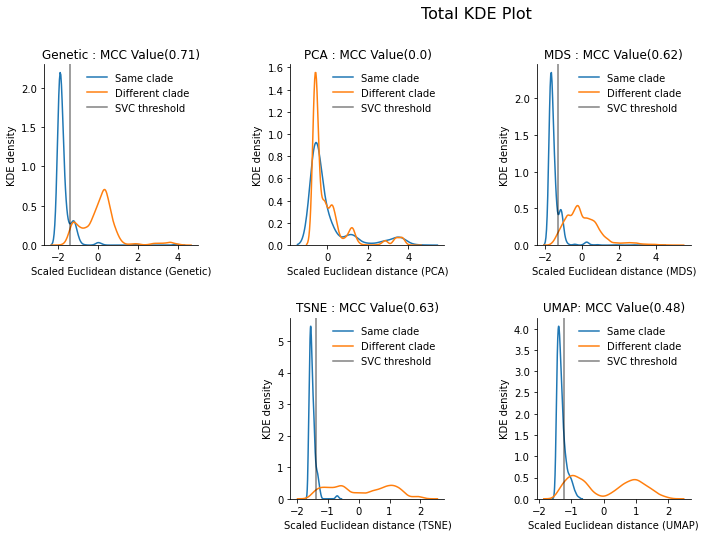

In [8]:
#fig, axes = plt.subplots(1, 5, figsize=(40, 8))
fig = plt.figure(figsize=(16, 8), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.4, wspace=0.6)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])



#GENETIC 
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax1)
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax1)
ax1.axvline(x=Genetic_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax1.legend(frameon=False)
ax1.set_title('Genetic : MCC Value(' + str(round(Genetic_KDE_metadata_df["MCC"].values.tolist()[0],2))+ ')')
ax1.set_xlabel("Scaled Euclidean distance (Genetic)")
ax1.set_ylabel("KDE density")

#PCA
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax2)
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax2)
ax2.axvline(x=PCA_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax2.legend(frameon=False)
ax2.set_title('PCA : MCC Value(' + str(round(PCA_KDE_metadata_df["MCC"].values.tolist()[0],2))+ ')')
ax2.set_xlabel("Scaled Euclidean distance (PCA)")
ax2.set_ylabel("KDE density")

#MDS
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax3)
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax3)
ax3.axvline(x=MDS_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax3.legend(frameon=False)
ax3.set_title('MDS : MCC Value(' + str(round(MDS_KDE_metadata_df["MCC"].values.tolist()[0],2))+ ')')
ax3.set_xlabel("Scaled Euclidean distance (MDS)")
ax3.set_ylabel("KDE density")

#TSNE
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax4)
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax4)
ax4.axvline(x=TSNE_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax4.legend(frameon=False)
ax4.set_title('TSNE : MCC Value(' + str(round(TSNE_KDE_metadata_df["MCC"].values.tolist()[0],2))+ ')')
ax4.set_xlabel("Scaled Euclidean distance (TSNE)")
ax4.set_ylabel("KDE density")

#UMAP
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Same clade", ax=ax5)
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Different clade", ax=ax5)
ax5.axvline(x=UMAP_KDE_metadata_df["threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)
ax5.legend(frameon=False)
ax5.set_title('UMAP: MCC Value(' + str(round(UMAP_KDE_metadata_df["MCC"].values.tolist()[0],2))+ ')')
ax5.set_xlabel("Scaled Euclidean distance (UMAP)")
ax5.set_ylabel("KDE density")

sns.despine()
plt.savefig(snakemake.output.KDE_density, dpi=600, bbox_inches='tight')

In [86]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds' + str(i) for i in range(1,11)],['MDS' + str(i) for i in range(1,11)], 'multihost_clade_membership:N', ['strain','multihost_clade_membership'], domain, range_)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]

chart.save(snakemake.output.MDS_Supplement)
chart.save(snakemake.output.MDS_Supplement_PNG)

In [87]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca' + str(i) for i in range(1,11)],['PCA' + str(i) for i in range(1,11)], 'multihost_clade_membership:N', ['strain','multihost_clade_membership'], domain, range_)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]

chart.save(snakemake.output.PCA_Supplement)
chart.save(snakemake.output.PCA_Supplement_PNG)

# HDBSCAN Final Charts

In [6]:
node_df = pd.read_csv("results/table.tsv", sep="\t")
#node_df = pd.read_csv(node_df, sep="\t")
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)

In [7]:
colors = pd.read_csv("../notebooks/config/color_schemes.tsv", sep="\t", names=[i for i in range(0,101)])
#colors = pd.read_csv(colors, sep="\t", names=[i for i in range(0,101)])

In [8]:
PCA_df = pd.read_csv("results/embed_pca.csv",index_col=0)
MDS_df = pd.read_csv("results/embed_mds.csv",index_col=0)
TSNE_df = pd.read_csv("results/embed_t-sne.csv",index_col=0)
UMAP_df = pd.read_csv("results/embed_umap.csv",index_col=0)
explained_variance_df = pd.read_csv("results/explained_variance_pca.csv")


#PCA_df = pd.read_csv(pca_df,index_col=0)
#MDS_df = pd.read_csv(mds_df,index_col=0)
#TSNE_df = pd.read_csv(tsne_df,index_col=0)
#UMAP_df = pd.read_csv(umap_df,index_col=0)
#explained_variance_df = pd.read_csv(explained_variance_pca)

In [11]:
merged_df = node_df[["strain", "date", "multihost_clade_membership", "y", "host"]].merge(
    PCA_df,
    on="strain"
).merge(
    MDS_df,
    on="strain"
).merge(
    TSNE_df,
    on="strain"
).merge(
    UMAP_df,
    on="strain"
)

In [125]:
from Helpers import get_euclidean_data_frame
from sklearn.metrics import confusion_matrix, matthews_corrcoef

In [126]:
def _get_embedding_columns_by_method(method):
    if method in ("pca"):
        return list(f"{method}1 {method}2 {method}3 {method}4 {method}5 {method}6 {method}7 {method}8 {method}9 {method}10".split())
    if method in ("mds"):
        return list(f"{method}1 {method}2".split())
    if method in ("t-sne"):
        return list("tsne_x tsne_y".split())
    else:
        return list(f"{method}_x {method}_y".split())

In [129]:
MCC_val = []

for method in ["pca", "mds", "t-sne", "umap"]:
    KDE_df_normal = get_euclidean_data_frame(sampled_df=merged_df, column_for_analysis="multihost_clade_membership", embedding="method", column_list=_get_embedding_columns_by_method(method))

    KDE_df_cluster =  get_euclidean_data_frame(sampled_df=merged_df, column_for_analysis=f"{method}_label", embedding="method", column_list=_get_embedding_columns_by_method(method))

    confusion_matrix_val = confusion_matrix(KDE_df_normal["clade_status"], KDE_df_cluster["clade_status"])
    matthews_cc_val = matthews_corrcoef(KDE_df_normal["clade_status"], KDE_df_cluster["clade_status"])
    MCC_val.append(matthews_cc_val)

In [13]:
domain =  sorted(merged_df["pca_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
PCA = linking_tree_with_plots_brush_mers(
    merged_df,
    ['pca1', 'pca2'],
    ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_df["explained variance"][0]*100,2)) + ")",
    'PCA2 (Explained Variance : {}%'.format(round(explained_variance_df["explained variance"][1]*100,2)) + ")"],
    'pca_label:N',
    ['strain','host', 'multihost_clade_membership'],
    'host:N',
    domain,
    range_
)
domain =  sorted(merged_df["mds_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
MDS = linking_tree_with_plots_brush_mers(
    merged_df,
    ['mds1', 'mds2'],
    ['MDS1', 'MDS2'],
    'mds_label:N',
    ['strain','host', 'multihost_clade_membership'],
    'host:N',
    domain,
    range_
)
domain =  sorted(merged_df["t-sne_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
TSNE = linking_tree_with_plots_brush_mers(
    merged_df,
    ['tsne_x', 'tsne_y'],
    ['TSNE1', 'TSNE2'],
    't-sne_label:N',
    ['strain','host', 'multihost_clade_membership'],
    'host:N',
    domain,
    range_
)
domain =  sorted(merged_df["umap_label"].drop_duplicates().values)
if -1 in domain:
    range_ = ["#999999"] + colors[len(domain)-1:len(domain)].dropna(axis=1).values.tolist()[0]
else: 
    range_ = colors[len(domain):len(domain)+1].dropna(axis=1).values.tolist()[0]
UMAP = linking_tree_with_plots_brush_mers(
    merged_df,
    ['umap_x', 'umap_y'],
    ['UMAP1', 'UMAP2'],
    'umap_label:N',
    ['strain','host', 'multihost_clade_membership'],
    'host:N',
    domain,
    range_
)

NameError: name 'linking_tree_with_plots_brush_mers' is not defined

In [149]:
PCAChart = PCA[0]|PCA[1].properties(title= "MCC Value: " + str(round(MCC_val[0],3)))
MDSChart = MDS[0]|MDS[1].properties(title= "MCC Value: " + str(round(MCC_val[1],3)))
TSNEChart = TSNE[0]|TSNE[1].properties(title= "MCC Value: " + str(round(MCC_val[2],3)))
UMAPChart = UMAP[0]|UMAP[1].properties(title= "MCC Value: " + str(round(MCC_val[3],3)))

In [150]:
PCAMDS = alt.vconcat(PCAChart, MDSChart).resolve_scale(color='independent')
TSNEUMAP = alt.vconcat(TSNEChart, UMAPChart).resolve_scale(color='independent')
fullChart = alt.vconcat(PCAMDS, TSNEUMAP).resolve_scale(color='independent')
fullChart
fullChart.save(snakemake.output.fullChartHDBSCAN)
save(fullChart, snakemake.output.fullChartHDBSCANPNG, scale_factor=2.0)

alt.VConcatChart(...)